# Imports


In [ ]:
import matplotlib
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.stats.api as sms
import statsmodels.api as sm
import statsmodels.stats as stats1
import matplotlib.pyplot as pyplot
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.cluster import DBSCAN
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PowerTransformer
from scipy.stats import iqr
from sklearn.externals import joblib
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from IPython.display import HTML # toto je tu len pre to aby sa mi obrazok zmestil na obrazovku
from sklearn.tree import export_graphviz
from graphviz import Source
from IPython.display import SVG
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# Pipeline declaration

#### Duplicates

In [ ]:
def remove_duplicates(df_t):
  filledgroups_f = df_t.groupby(["name", "address"]).apply(lambda x: x.ffill().bfill())
  df_t = filledgroups_f
  df_t.drop_duplicates(inplace=True)
  df_t = df_t.reset_index(drop=True)
  return df_t

#### Date format

In [ ]:
def future_date(x):
  if (pd.to_datetime(x) > pd.to_datetime('01/01/2018')):
    return (pd.to_datetime(x)-pd.DateOffset(years=100)).strftime('%d/%m/%Y')
  else:
    return x

def dateformat_consistent(df_t):
  df_t.date_of_birth = df_t.date_of_birth.apply(lambda x: pd.to_datetime(x[:10], yearfirst=True).strftime('%d/%m/%Y'))
  df_t.date_of_birth=df_t.date_of_birth.apply(future_date)
  return df_t

#### Age

In [ ]:
def age_to_normal(df_t):
  now = pd.to_datetime('now')
  df_t.age =(now - pd.to_datetime(df_t.date_of_birth)).astype('<m8[Y]').astype("int64")
  return df_t

#### Gender

In [ ]:
def gender_to_normal(df_t):
  df_t.sex = df_t.sex.apply(lambda x: x[1:])
  return df_t

#### Pregnancy

In [ ]:
def pregnant_to_normal(df_t):
  df_t.pregnant = df_t.pregnant.replace(['F', 'FALSE', 'f'], False)
  df_t.pregnant = df_t.pregnant.replace(['T', 'TRUE', 't'], True)
  df_t.loc[df_t["sex"]=='Male', "pregnant"] = False
  return df_t

#### Metrics

In [ ]:
def str_to_float(x):
  try:
    return float(x)
  except ValueError:
    return np.nan

def metrics(df_t):
  df_t.mean_glucose =df_t.mean_glucose.apply(str_to_float)
  imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
  x_t = imp_mean.fit_transform(df_t[["mean_glucose", "class"]])
  df_t["mean_glucose"]=x_t[:,0]

  imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
  x_t = imp_mean.fit_transform(df_t[["kurtosis_glucose", "class"]])
  df_t["kurtosis_glucose"]=x_t[:,0]

  imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
  x_t = imp_median.fit_transform(df_t[["std_oxygen", "class"]])
  df_t["std_oxygen"]=x_t[:,0]

  imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
  x_t = imp_median.fit_transform(df_t[["kurtosis_oxygen", "class"]])
  df_t["kurtosis_oxygen"]=x_t[:,0]

  KNN_imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
  X_t =KNN_imputer.fit_transform(df_t[['mean_oxygen', 'class']])
  df_t.mean_oxygen=X_t[:,0]

  KNN_imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
  X_t =KNN_imputer.fit_transform(df_t[['std_glucose', 'class']])
  df_t.std_glucose=X_t[:,0]

  imp_most_frequent = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
  x_t = imp_most_frequent.fit_transform(df_t[["skewness_oxygen", "class"]])
  df_t["skewness_oxygen"]=x_t[:,0]

  imp_most_frequent = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
  x_t = imp_most_frequent.fit_transform(df_t[["skewness_glucose", "class"]])
  df_t["skewness_glucose"]=x_t[:,0]

  X_t =KNN_imputer.fit_transform(df_t[['class', "std_glucose"]])
  df_t["class"]=X_t[:,0]
  return df_t

#### Occupation

In [ ]:
def float_to_str(x):
  try:
    return str(x)
  except ValueError:
    return "  "
    
def occupation_to_normal(df_t):
  occupation =df_t.occupation.apply(float_to_str).replace('nan', " nan").apply(lambda x: x[1:])
  occupation =occupation.replace('?', np.nan).replace('nan', np.nan).replace('', np.nan)
  df_t.occupation=occupation

  imp_most_frequent = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
  x_t = imp_most_frequent.fit_transform(df_t[["occupation", "class"]])
  df_t["occupation"]=x_t[:,0]
  return df_t

#### Personal info

In [ ]:
def personal_info_to_normal(df_t):
  personal_info=df_t["personal_info"].apply(float_to_str)
  personal_info= personal_info.replace("nan", "nan|nan\r\r\nnan -- nan|nan")
  df_splited=personal_info.apply(float_to_str).str.split("|", n=1)
  
  df_t["race"]=df_splited.apply(lambda x: x[0]).replace("nan", np.nan)
  
  df_splited2=df_splited.apply(lambda x:x[1])
  
  df_t["country"]=df_splited2.str.split("\r", n=1).apply(lambda x:x[0]).replace("nan", np.nan).replace("?", np.nan)
  df_splited3=df_splited2.str.split("\n", n=1).apply(lambda x:x[1]).str.split(" -- ", n=1).apply(lambda x:x[1]).str.split("|", n=1)
  
  df_t["marriage"]=df_splited3.apply(lambda x: x[0]).replace("nan", np.nan)
  
  df_t["family_state"]=df_splited3.apply(lambda x: x[1]).replace("nan", np.nan)
  
  df_t.drop('personal_info', axis='columns', inplace=True)
  
  imp_most_frequent = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
  x_t = imp_most_frequent.fit_transform(df_t[["race", "class"]])
  df_t["race"]=x_t[:,0]

  x_t = imp_most_frequent.fit_transform(df_t[["country", "class"]])
  df_t["country"]=x_t[:,0]

  x_t = imp_most_frequent.fit_transform(df_t[["marriage", "class"]])
  df_t["marriage"]=x_t[:,0]

  x_t = imp_most_frequent.fit_transform(df_t[["family_state", "class"]])
  df_t["family_state"]=x_t[:,0]

  return df_t
  

#### Address

In [ ]:
def get_state(x):
  x=x.split(", ")
  if(len(x)>1):
    return x[1].split(" ")[0]
  return x[0].split(" ")[1]

def get_postcode(x):
  x=x.split(", ")
  if(len(x)>1):
    return x[1].split(" ")[1]
  return x[0].split(" ")[2]

def hasNumbers(inputString):
  return any(char.isdigit() for char in inputString)

def get_city(x):
  if( hasNumbers(x) ):
    return x.split(" ")[0]
  else: 
    return x
    
def address_to_normal(df_t):
  address=df_t.address
  address=address.replace('nan', 'nan\r\nnan, nan nan')
  df_t.address=address

  df_t["street_address"]=df_t.address.str.split("\r").apply(lambda x: x[0])

  df_t["state"]=df_t.address.str.split("\n").apply(lambda x: x[1]).apply(get_state)
  
  df_t["postcode"]=df_t.address.str.split("\n").apply(lambda x: x[1]).apply(get_postcode)

  df_t["city"]=df_t.address.str.split("\n").apply(lambda x: x[1]).str.split(",").apply(lambda x: x[0]).apply(get_city)

  df_t.drop('address',
  axis='columns', inplace=True)

  imp_most_frequent = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
  
  x_t = imp_most_frequent.fit_transform(df_t[["state", "class"]])
  df_t["state"]=x_t[:,0]

  x_t = imp_most_frequent.fit_transform(df_t[["street_address", "class"]])
  df_t["street_address"]=x_t[:,0]

  x_t = imp_most_frequent.fit_transform(df_t[["postcode", "class"]])
  df_t["postcode"]=x_t[:,0]

  x_t = imp_most_frequent.fit_transform(df_t[["city", "class"]])
  df_t["city"]=x_t[:,0]

  return df_t



#### Other information

In [ ]:
def others_to_normal(df_t):

  imp_most_frequent = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

  x_t = imp_most_frequent.fit_transform(df_t[["fnlwgt", "class"]])
  df_t["fnlwgt"]=x_t[:,0]

  df_t["workclass"]=df_t.workclass.apply(lambda x: x[1:]).replace("?", np.nan)
  x_t = imp_most_frequent.fit_transform(df_t[["workclass", "class"]])
  df_t["workclass"]=x_t[:,0]

  x_t = imp_most_frequent.fit_transform(df_t[["income", "class"]])
  df_t["income"]=x_t[:,0]
  return df_t

#### Outliers

In [ ]:
def identify_outliers(a, k, q):
    med=a.quantile(0.75)-a.quantile(0.25)
    lower = df_train.std_oxygen.quantile(q)-k*med
    upper=df_train.std_oxygen.quantile(1-q)+k*med
    return a[(a > upper) | (a < lower)]

def identify_outliers_upper(a, k, q):
    med=a.quantile(0.75)-a.quantile(0.25)
    lower = df_train.std_oxygen.quantile(q)-k*med
    upper=df_train.std_oxygen.quantile(1-q)+k*med
    return a[a > upper]

def identify_outliers_lower(a, k, q):
    med=a.quantile(0.75)-a.quantile(0.25)
    lower = df_train.std_oxygen.quantile(q)-k*med
    upper=df_train.std_oxygen.quantile(1-q)+k*med
    return a[a < lower]

def change_outliers(df_t):
  df_normal_std_oxygen_1= df_t["std_oxygen"]
  df_normal_std_oxygen_out =identify_outliers(df_normal_std_oxygen_1, 0.1, 0.25)
  df_t = df_t.drop(df_normal_std_oxygen_out.index)
  df_t = df_t.reset_index(drop=True)

  df_normal_std_glucose_1= df_t["std_glucose"]
  df_normal_std_glucose_out =identify_outliers(df_normal_std_glucose_1,-2.5, 0.05)
  df_t = df_t.drop(df_normal_std_glucose_out.index)
  df_t = df_t.reset_index(drop=True)

  df_normal_skewness_oxygen_1= df_t["skewness_oxygen"]
  df_normal_skewness_oxygen_out_1 =identify_outliers_lower(df_normal_skewness_oxygen_1,  0.1, 0.25)
  
  df_normal_skewness_oxygen_2= df_t["skewness_oxygen"]
  df_normal_skewness_oxygen_out_2 =identify_outliers_upper(df_normal_skewness_oxygen_2, 0.1, 0.25)

  df_t.loc[df_normal_skewness_oxygen_out_1.index,'skewness_oxygen'] = df_t.skewness_oxygen.quantile(0.05)
  df_t.loc[df_normal_skewness_oxygen_out_2.index,'skewness_oxygen'] = df_t.skewness_oxygen.quantile(0.95)
  
  return df_t

#### Power Transformer

In [ ]:
def power_t(df_t):
  power_std_oxygen = PowerTransformer(method='yeo-johnson', standardize=True) 
  data_trans_std_oxygen = power_std_oxygen.fit_transform(df_t[["std_oxygen", "class"]])

  power_std_glucose = PowerTransformer(method='yeo-johnson', standardize=True) 
  data_trans_std_glucose = power_std_glucose.fit_transform(df_t[["std_glucose", "class"]])

  df_t["std_oxygen"]=data_trans_std_oxygen[:,0]
  df_t["std_glucose"]=data_trans_std_glucose[:,0]
  # df_t["class"]=data_trans_std_glucose[:,1]
  return df_t;

#### Text data normalization

In [ ]:
def text_normalize(df_t):
  count_vect = CountVectorizer()

  df_t.drop('race', axis='columns', inplace=True)

  X_train_counts = count_vect.fit_transform(df_t.country)
  df_t.country=X_train_counts.toarray().tolist()

  X_train_counts = count_vect.fit_transform(df_t.workclass)
  df_t.workclass=X_train_counts.toarray().tolist()

  df_t.drop('family_state', axis='columns', inplace=True)
  df_t.drop('marriage', axis='columns', inplace=True)

  df_t.rename(columns = {'income': 'income>50K', 'sex': 'Male' }, inplace=True)
  df_t["income>50K"]=df_t["income>50K"].replace(" >50K", 1).replace(" <=50K", 0)

  df_t.drop('state', axis='columns', inplace=True)
  df_t.drop('postcode', axis='columns', inplace=True)
  df_t.drop('city', axis='columns', inplace=True)
  df_t.drop('street_address', axis='columns', inplace=True)

  X_train_counts = count_vect.fit_transform(df_t.occupation)
  df_t.occupation=X_train_counts.toarray().tolist()

  df_t.Male=df_t.Male.replace("Male", 1).replace("Female", 0)

  df_t.drop('pregnant', axis='columns', inplace=True)
  df_t.drop('name', axis='columns', inplace=True)
  df_t.drop('date_of_birth', axis='columns', inplace=True)
  return df_t


# Preprocessing validation datasets

### Let's load validation datasets first

In [ ]:
def load_data():
  df_train_personal = pd.read_csv("personal_valid.csv")
  df_train_other = pd.read_csv("other_valid.csv")
  df_train_personal.drop(['Unnamed: 0'], axis='columns', inplace=True)
  df_train_other.drop(['Unnamed: 0'], axis='columns', inplace=True)
  df_train =pd.merge(df_train_personal, df_train_other, on=["name", "address"])
  return df_train

In [ ]:
trans_duplicates = FunctionTransformer(remove_duplicates)
trans_date = FunctionTransformer(dateformat_consistent)
trans_age = FunctionTransformer(age_to_normal)
trans_gender = FunctionTransformer(gender_to_normal)
trans_pregnant = FunctionTransformer(pregnant_to_normal)
trans_metrics = FunctionTransformer(metrics)
trans_occupation = FunctionTransformer(occupation_to_normal)
trans_personal_info = FunctionTransformer(personal_info_to_normal)
trans_address = FunctionTransformer(address_to_normal)
trans_others = FunctionTransformer(others_to_normal)
trans_outliers = FunctionTransformer(change_outliers)
trans_power = FunctionTransformer(power_t)
trans_text = FunctionTransformer(text_normalize)

sk_pipe = Pipeline([("duplicates", trans_duplicates), 
                    ("date", trans_date),
                    ("age", trans_age),
                    ("gender", trans_gender),
                    ("pregnancy", trans_pregnant),
                    ("metrics", trans_metrics),
                    ("occupation", trans_occupation),
                    ("personal_info", trans_personal_info),
                    ("address", trans_address),
                    ("others", trans_others),
                    ("outliers", trans_outliers),
                    ("power", trans_power),
                    ("text", trans_text)])
df_train = load_data()
df_train_normilize = sk_pipe.transform(df_train)
df_train_normilize

,age,Male,kurtosis_oxygen,occupation,education-num,skewness_glucose,mean_glucose,std_oxygen,capital-gain,skewness_oxygen,kurtosis_glucose,fnlwgt,class,std_glucose,income>50K,mean_oxygen,hours-per-week,capital-loss,workclass,country
0,35,0,11.901183,"[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10.0,1.100895,100.952226,-1.709603,0.0,209.956860,0.538392,145656.0,0.0,-1.245527,0,1.657191,24.0,0.0,"[0, 0, 0, 0, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,53,0,7.293155,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9.0,0.627064,93.109375,0.670061,0.0,209.956860,0.445701,131068.0,0.0,-0.335976,0,3.896321,40.0,0.0,"[0, 0, 0, 0, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,43,1,6.849557,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",13.0,0.132196,107.054688,0.071887,0.0,55.304186,0.244217,156800.0,0.0,-0.475976,0,3.598662,50.0,0.0,"[1, 0, 0, 1, 0, 1, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,46,1,10.839312,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",11.0,-0.146138,109.328125,-0.757267,0.0,209.956860,0.380494,306352.0,0.0,0.884352,0,2.132107,40.0,0.0,"[0, 0, 0, 0, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
4,52,1,7.153364,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10.0,0.891195,100.952226,0.554452,0.0,55.738168,0.320338,311177.0,0.0,-1.118334,0,3.721572,30.0,0.0,"[1, 0, 0, 1, 0, 1, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
736,43,1,8.480384,"[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10.0,0.074881,118.789062,-0.930520,0.0,209.956860,0.160317,107190.0,0.0,-0.226072,0,2.751672,20.0,0.0,"[0, 0, 0, 0, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
737,43,1,10.590977,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",14.0,0.698647,121.859375,-1.553557,0.0,209.956860,0.247989,107302.0,0.0,-0.821247,0,2.071906,40.0,0.0,"[0, 0, 0, 0, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
738,59,1,8.721704,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10.0,-0.035706,121.101562,-0.699732,0.0,209.956860,0.236479,189530.0,0.0,-0.762749,0,2.572742,35.0,0.0,"[0, 0, 0, 0, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
739,45,0,5.193876,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9.0,0.177381,100.952226,0.453913,0.0,33.179282,0.075181,105281.0,0.0,0.143274,0,5.558528,40.0,1974.0,"[0, 0, 0, 0, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### As we can see no Nan or other inappropriate value accures. So our pipeline doesn't need any changes.



# Manual creating and evaluating decision rules for classification 

### Defining rules:

1.  metr_o:
        1.1 if 0<=std_oxygen<=2 then class=1 (presence of the disease)
        1.2 else class=0 (no disease)

2.  metr_g:
        2.1 if -2<=std_oxygen<=0 then class=1 (presence of the disease)
        2.2 else class=0 (no disease)

3. metr - combine above rules.



In [ ]:
def metr_o(X):
  y=pd.DataFrame()
  for idx, row in X.iterrows():
    if (row['std_oxygen']>=0 and row['std_oxygen']<=2):
      y = pd.concat([y, pd.DataFrame([[1]], columns=['class'])])
    else:
      y = pd.concat([y, pd.DataFrame([[0]], columns=['class'])])
  return y

def metr_g(X):
  y=pd.DataFrame()
  for idx, row in X.iterrows():
    if (row['std_glucose']>=-2 and row['std_glucose']<=0):
      y = pd.concat([y, pd.DataFrame([[1]], columns=['class'])])
    else:
      y = pd.concat([y, pd.DataFrame([[0]], columns=['class'])])
  return y

def metr(X):
  y=pd.DataFrame()
  for idx, row in X.iterrows():
    if (row['std_oxygen']>=0 and row['std_oxygen']<=2):
      if (row['std_glucose']>=-2 and row['std_glucose']<=0):
        y = pd.concat([y, pd.DataFrame([[1]], columns=['class'])])
      else:
        y = pd.concat([y, pd.DataFrame([[0]], columns=['class'])])
    else:
      y = pd.concat([y, pd.DataFrame([[0]], columns=['class'])])
  return y

#### Decision based only on the first rule (metr_o)

In [ ]:
X = df_train_normilize.loc[df_train_normilize.index >= 10, ['std_oxygen']]
y = df_train_normilize.loc[df_train_normilize.index >= 10, 'class']
y1 = metr_o(X)
print("Accuracy: ",accuracy_score(y, y1))
print("Precision: ",precision_score(y, y1))
print("Recall: ",recall_score(y, y1))

Accuracy:  0.5786593707250342
Precision:  0.175
Recall:  0.8513513513513513


#### Decision based only on the second rule (metr_g)

In [ ]:
X = df_train_normilize.loc[df_train_normilize.index >= 10, ['std_glucose']]
y = df_train_normilize.loc[df_train_normilize.index >= 10, 'class']
y1 = metr_g(X)
print("Accuracy: ",accuracy_score(y, y1))
print("Precision: ",precision_score(y, y1))
print("Recall: ",recall_score(y, y1))

Accuracy:  0.5841313269493844
Precision:  0.16569767441860464
Recall:  0.7702702702702703


#### Decision based only on the third rule (metr)

In [ ]:
X = df_train_normilize.loc[df_train_normilize.index >= 10, ['std_oxygen', 'std_glucose']]
y = df_train_normilize.loc[df_train_normilize.index >= 10, 'class']
y1 = metr(X)
print("Accuracy: ",accuracy_score(y, y1))
print("Precision: ",precision_score(y, y1))
print("Recall: ",recall_score(y, y1))

Accuracy:  0.8153214774281806
Precision:  0.3081761006289308
Recall:  0.6621621621621622


#### To sum up, taking two values (std_oxygen and std_glucose) into consideration has better results than taking only one of the values.

# Training and evaluating of classificator using decision trees

### First training is based only on 'std_oxygen' parameter

In [ ]:
cls = DecisionTreeClassifier(criterion='entropy')
X = df_train_normilize.loc[df_train_normilize.index < 20, ['std_oxygen']]
y = df_train_normilize.loc[df_train_normilize.index < 20, 'class']
cls.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

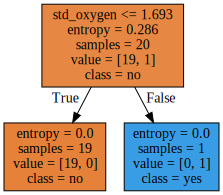

In [ ]:
graph = Source(export_graphviz(cls, 
                               out_file=None,
                               feature_names=['std_oxygen'],
                               class_names=['no', 'yes'],
                               filled = True))
display(SVG(graph.pipe(format='svg')))

style = "<style>svg{width:30% !important;height:30% !important;}</style>"
HTML(style)

### Here are results of first training

In [ ]:
X = df_train_normilize.loc[df_train_normilize.index >= 20, ['std_oxygen']]
y = df_train_normilize.loc[df_train_normilize.index >= 20, 'class']
y1 = cls.predict(X)

print("Accuracy: ",accuracy_score(y, y1))
print("Precision: ",precision_score(y, y1))
print("Recall: ",recall_score(y, y1))

Accuracy:  0.9042995839112344
Precision:  0.5675675675675675
Recall:  0.28378378378378377


### We will use 'std_oxygen' in the second training

In [ ]:
cls = DecisionTreeClassifier(criterion='entropy')
X = df_train_normilize.loc[df_train_normilize.index < 20, ['std_glucose']]
y = df_train_normilize.loc[df_train_normilize.index < 20, 'class']
cls.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

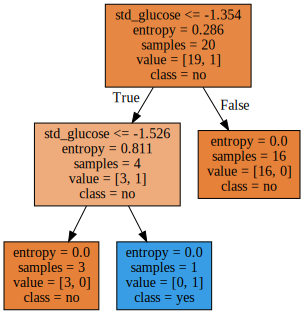

In [ ]:
graph = Source(export_graphviz(cls, 
                               out_file=None,
                               feature_names=['std_glucose'],
                               class_names=['no', 'yes'],
                               filled = True))
display(SVG(graph.pipe(format='svg')))

style = "<style>svg{width:30% !important;height:30% !important;}</style>"
HTML(style)

### Here are results for the second one

In [ ]:
X = df_train_normilize.loc[df_train_normilize.index >= 20, ['std_glucose']]
y = df_train_normilize.loc[df_train_normilize.index >= 20, 'class']
y1 = cls.predict(X)

print("Accuracy: ",accuracy_score(y, y1))
print("Precision: ",precision_score(y, y1))
print("Recall: ",recall_score(y, y1))

Accuracy:  0.8779472954230236
Precision:  0.23076923076923078
Recall:  0.08108108108108109


### Now both of the parametres are used in the training

In [ ]:
cls = DecisionTreeClassifier(criterion='entropy')
df0 = df_train_normilize.loc[df_train_normilize['class']==0][:10]
df1 = df_train_normilize.loc[df_train_normilize['class']==1][:10]
df = pd.concat([df0, df1])
X = df[['std_glucose', 'std_oxygen']]
y = df[['class']]
cls.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

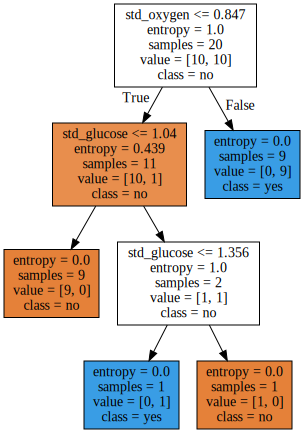

In [ ]:
graph = Source(export_graphviz(cls, 
                               out_file=None,
                               feature_names=['std_glucose', 'std_oxygen'],
                               class_names=['no', 'yes'],
                               filled = True))
display(SVG(graph.pipe(format='svg')))

style = "<style>svg{width:30% !important;height:30% !important;}</style>"
HTML(style)

### Results of the last training

In [ ]:
X = df_train_normilize.loc[df_train_normilize['class']==0, ['std_glucose', 'std_oxygen']][10:]
X1 = df_train_normilize.loc[df_train_normilize['class']==1, ['std_glucose', 'std_oxygen']][10:]
X= pd.concat([X, X1])
y = df_train_normilize.loc[df_train_normilize['class']==0, ['class']][10:]
y1 = df_train_normilize.loc[df_train_normilize['class']==1, ['class']][10:]
y= pd.concat([y, y1])
y_res = cls.predict(X)

print("Accuracy: ",accuracy_score(y, y_res))
print("Precision: ",precision_score(y, y_res))
print("Recall: ",recall_score(y, y_res))

Accuracy:  0.7406380027739251
Precision:  0.21495327102803738
Recall:  0.7076923076923077


### As we can see the best result was reached based on 'std_oxygen' parameter. It is better than both manual and using decision trees trainings.

# Hyperparameter tuning

In [ ]:
df_train_normilize.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 741 entries, 0 to 740
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               741 non-null    int64  
 1   Male              741 non-null    int64  
 2   kurtosis_oxygen   741 non-null    float64
 3   occupation        741 non-null    object 
 4   education-num     741 non-null    float64
 5   skewness_glucose  741 non-null    float64
 6   mean_glucose      741 non-null    float64
 7   std_oxygen        741 non-null    float64
 8   capital-gain      741 non-null    float64
 9   skewness_oxygen   741 non-null    float64
 10  kurtosis_glucose  741 non-null    float64
 11  fnlwgt            741 non-null    float64
 12  class             741 non-null    float64
 13  std_glucose       741 non-null    float64
 14  income>50K        741 non-null    int64  
 15  mean_oxygen       741 non-null    float64
 16  hours-per-week    740 non-null    float64
 1

#### Checking wheteher we have reached overfitting

In [ ]:
results = []
estimators = []
X_train, X_test, y_train, y_test = train_test_split(df_train_normilize[['std_glucose', 'std_oxygen']], df_train_normilize[['class']], test_size=0.2, random_state=4)
for i in range(1, X_train.shape[1] + 1):  
    row = {'model_complexity': i}
    
    clf = DecisionTreeClassifier(max_depth = i) 
    
    pred = clf.fit(X_train, y_train).predict(X_train) 
    
    row['train'] = 1-accuracy_score(y_train, pred) 
    
    pred = clf.predict(X_test)
    
    row['test'] = 1-accuracy_score(y_test, pred) 
    results.append(row)
    estimators.append(clf)

In [ ]:
complexity_df = pd.DataFrame(results)
complexity_df.head()

,model_complexity,train,test
0,1,0.094595,0.093960
1,2,0.060811,0.087248


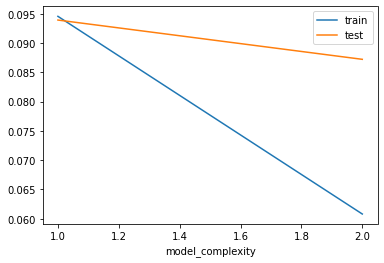

In [ ]:
complexity_df.plot(x='model_complexity')

#### As we can see, the bigger model complexity  is the worse results are, that means that there is no overfitting

In [ ]:
def plot_valid_curve(param_range, train_scores_mean, train_scores_std, test_scores_mean, test_scores_std):
    plt.title("Validation Curve")
    plt.xlabel(r"$\gamma$")
    plt.ylabel("Score")
    # plt.si
    # plt.ylim(0.991, 1.001)
    lw = 2
    plt.semilogx(param_range, 
                 train_scores_mean, 
                 label="Training score",
                 color="darkorange", 
                 lw=lw
                )
    plt.fill_between(param_range, 
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, 
                     alpha=0.2,
                     color="darkorange", 
                     lw=lw
                    )
    plt.semilogx(param_range, 
                 test_scores_mean, 
                 label="Cross-validation score",
                 color="navy", 
                 lw=lw
                )
    plt.fill_between(param_range, 
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, 
                     alpha=0.2,
                     color="navy", 
                     lw=lw
                    )
    plt.legend(loc="best")    
    return

#### Next step is to find best hyperparameters.

#### Below we test only one hyperparameter

In [ ]:
# param_range = [{"std_glucose":1, "std_oxygen":2}, {"std_glucose":2, "std_oxygen":1}, {"std_glucose":1, "std_oxygen":1},{"std_glucose":1.5, "std_oxygen":2}, {"std_glucose":2, "std_oxygen":1.5}]
param_range = [{0: 1, 1: 1}, {0: 1, 1: 2},{0: 2, 1: 2}, {0: 2, 1: 1.5}, {0: 1.5, 1: 2}, {0:1, 1:3}, {0:3, 1:1}]
# param_range=[1,2,3,4,5]
train_scores, test_scores = validation_curve(DecisionTreeClassifier(),
                                             X = X_train, 
                                             y = y_train, 
                                             param_name = 'class_weight', 
                                             param_range = param_range, 
                                             scoring="accuracy",
                                             cv = 3
                                            )
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

print(train_scores)
print(test_scores)

[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
[[0.84848485 0.86294416 0.92385787]
 [0.8989899  0.89847716 0.90862944]
 [0.84848485 0.85786802 0.93401015]
 [0.85858586 0.85786802 0.91878173]
 [0.87878788 0.87817259 0.92385787]
 [0.86868687 0.89340102 0.91878173]
 [0.87878788 0.88832487 0.92893401]]


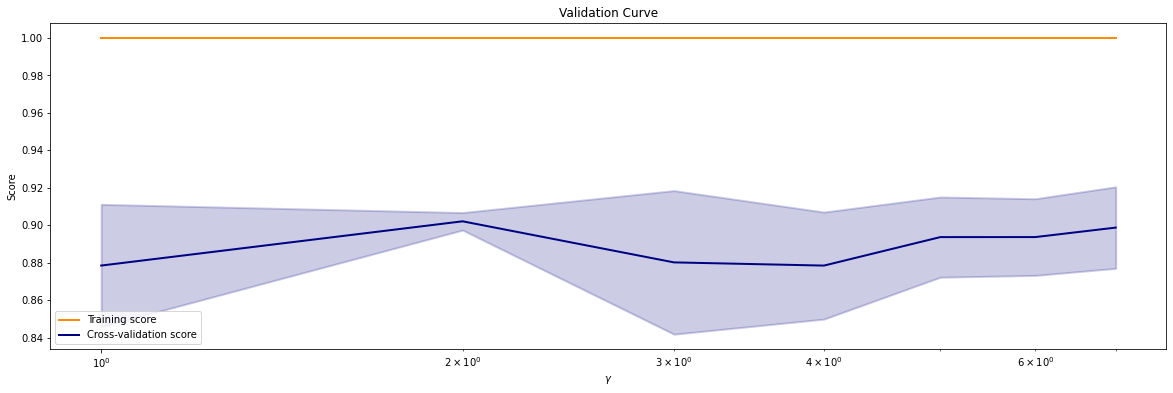

In [ ]:
plt.rcParams["figure.figsize"] = (20,6)
plot_valid_curve([1,2,3,4,5,6,7], train_scores_mean, train_scores_std, test_scores_mean, test_scores_std)

#### In this step we will try to find the best combination of the hyperparameters (class_weight and cpp_alpha) for the model basing on the accuracy score

In [ ]:
estimator = DecisionTreeClassifier()
parameters = {
    'class_weight':({0: 1, 1: 1}, {0: 1, 1: 2},{0: 2, 1: 2}, {0: 2, 1: 1.5}, {0: 1.5, 1: 2}, {0:1, 1:3}, {0:3, 1:1}), 
    'ccp_alpha':[0.0, 1.0, 2.0],

  }
scoring = ['accuracy',"recall", 'precision_micro']

clf = GridSearchCV(estimator=estimator, 
                   param_grid=parameters,
                   cv=5,
                   scoring=scoring,
                   refit='accuracy')

search = clf.fit(X_train, y_train)

print(search.best_estimator_)
print(search.best_params_)
print(search.n_splits_)


DecisionTreeClassifier(ccp_alpha=0.0, class_weight={0: 2, 1: 1.5},
                       criterion='gini', max_depth=None, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=None,
                       splitter='best')
{'ccp_alpha': 0.0, 'class_weight': {0: 2, 1: 1.5}}
5


#### So the best parametrs are :
    {
      ccp_alpha = 0.0, 
      class_weight = {0: 2, 1: 1.5}
    }


#### The results of the each hyperparameters combination are in the table and the plot bellow

In [ ]:
results= pd.DataFrame(search.cv_results_);
results[['param_ccp_alpha',	'param_class_weight','mean_test_accuracy', 'rank_test_accuracy','mean_test_precision_micro', 'rank_test_precision_micro','mean_test_recall','rank_test_recall' ]]


,param_ccp_alpha,param_class_weight,mean_test_accuracy,rank_test_accuracy,mean_test_precision_micro,rank_test_precision_micro,mean_test_recall,rank_test_recall
0,0,"{0: 1, 1: 1}",0.900385,3,0.900385,3,0.512121,1
1,0,"{0: 1, 1: 2}",0.903774,2,0.903774,2,0.510606,3
2,0,"{0: 2, 1: 2}",0.898690,18,0.898690,18,0.495455,5
3,0,"{0: 2, 1: 1.5}",0.905427,1,0.905427,1,0.512121,1
4,0,"{0: 1.5, 1: 2}",0.898661,19,0.898661,19,0.510606,3
5,0,"{0: 1, 1: 3}",0.891953,20,0.891953,20,0.490909,6
6,0,"{0: 3, 1: 1}",0.885159,21,0.885159,21,0.425758,7
7,1,"{0: 1, 1: 1}",0.900342,4,0.900342,4,0.000000,8
8,1,"{0: 1, 1: 2}",0.900342,4,0.900342,4,0.000000,8
9,1,"{0: 2, 1: 2}",0.900342,4,0.900342,4,0.000000,8


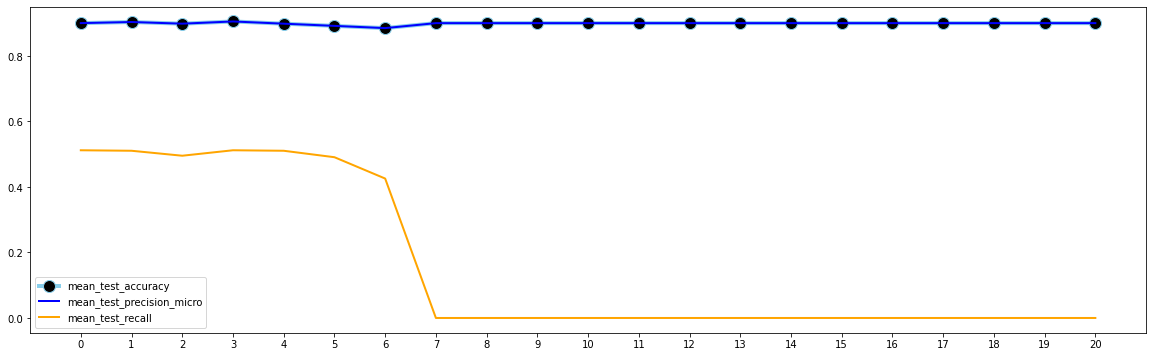

In [ ]:
import json
res2 = results
res2['params']=res2['params'].apply(lambda x: json.dumps(x))
results["index"]=results.index

plt.plot( "index",'mean_test_accuracy', data=res2, marker='o', markerfacecolor='black', markersize=12, color='skyblue', linewidth=4)
plt.plot( "index",'mean_test_precision_micro',  data=res2, marker='', color='blue', linewidth=2)
plt.plot( "index",'mean_test_recall', data=res2, marker='', color='orange', linewidth=2, )
plt.xticks(res2.index.tolist())
plt.legend()



#### The best results calculated by GridSearchCV()

In [ ]:
results.iloc[search.best_index_][['param_ccp_alpha',	'param_class_weight','mean_test_accuracy','mean_test_precision_micro', 'mean_test_recall' ]]

param_ccp_alpha                           0
param_class_weight           {0: 2, 1: 1.5}
mean_test_accuracy                 0.905427
mean_test_precision_micro          0.905427
mean_test_recall                   0.512121
Name: 3, dtype: object

#### The best results of the recreated model with best hyperparameters

In [ ]:
cls = DecisionTreeClassifier(criterion='entropy', class_weight= {0: 2, 1: 1.5})
df0 = df_train_normilize.loc[df_train_normilize['class']==0][:10]
df1 = df_train_normilize.loc[df_train_normilize['class']==1][:10]
df = pd.concat([df0, df1])
X = df[['std_glucose', 'std_oxygen']]
y = df[['class']]
cls.fit(X, y)

X = df_train_normilize.loc[df_train_normilize['class']==0, ['std_glucose', 'std_oxygen']][10:]
X1 = df_train_normilize.loc[df_train_normilize['class']==1, ['std_glucose', 'std_oxygen']][10:]
X= pd.concat([X, X1])
y = df_train_normilize.loc[df_train_normilize['class']==0, ['class']][10:]
y1 = df_train_normilize.loc[df_train_normilize['class']==1, ['class']][10:]
y= pd.concat([y, y1])
y_res = cls.predict(X)

print("Accuracy: ",accuracy_score(y, y_res))
print("Precision: ",precision_score(y, y_res))
print("Recall: ",recall_score(y, y_res))

Accuracy:  0.7406380027739251
Precision:  0.21495327102803738
Recall:  0.7076923076923077


# Evaluating the effect of the chosen strategy on classification accuracy

In [ ]:
def removeNAN(df_t):

  df_normal_std_glucose_out =df_t[df_t.std_glucose.isnull()]
  df_t = df_t.drop(df_normal_std_glucose_out.index)
  df_t = df_t.reset_index(drop=True)

  df_normal_std_oxygen_out =df_t[df_t.std_oxygen.isnull()]
  df_t = df_t.drop(df_normal_std_oxygen_out.index)
  df_t = df_t.reset_index(drop=True)

  return df_t

### Changing NaN values using Simple Imputer.

#### Instead of changing all NaN metrices, we will change only 'std_oxygen' and 'std_glucose' metrices With Simple Imputer

In [ ]:
def removeNAN_Simple(df_t):
  imp_most_frequent = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
  x_t = imp_most_frequent.fit_transform(df_t[["std_oxygen", "class"]])
  df_t["std_oxygen"]=x_t[:,0]

  imp_most_frequent = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
  x_t = imp_most_frequent.fit_transform(df_t[["std_glucose", "class"]])
  df_t["std_glucose"]=x_t[:,0]

  return df_t

In [ ]:
trans_duplicates = FunctionTransformer(remove_duplicates)
trans_date = FunctionTransformer(dateformat_consistent)
trans_age = FunctionTransformer(age_to_normal)
trans_gender = FunctionTransformer(gender_to_normal)
trans_pregnant = FunctionTransformer(pregnant_to_normal)
trans_metrics = FunctionTransformer(removeNAN_Simple)
trans_occupation = FunctionTransformer(occupation_to_normal)
trans_personal_info = FunctionTransformer(personal_info_to_normal)
trans_address = FunctionTransformer(address_to_normal)
trans_others = FunctionTransformer(others_to_normal)
trans_outliers = FunctionTransformer(change_outliers)
trans_power = FunctionTransformer(power_t)
trans_text = FunctionTransformer(text_normalize)

sk_pipe = Pipeline([("duplicates", trans_duplicates), 
                    ("date", trans_date),
                    ("age", trans_age),
                    ("gender", trans_gender),
                    ("pregnancy", trans_pregnant),
                    ("occupation", trans_occupation),
                    ("metrics", trans_metrics),
                    ("personal_info", trans_personal_info),
                    ("address", trans_address),
                    ("others", trans_others),
                    ("outliers", trans_outliers),
                    ("power", trans_power),
                    ("text", trans_text)])
df_train = load_data()
df_train_normilize = sk_pipe.transform(df_train)
df_train_normilize

,age,Male,kurtosis_oxygen,occupation,education-num,skewness_glucose,mean_glucose,std_oxygen,capital-gain,skewness_oxygen,kurtosis_glucose,fnlwgt,class,std_glucose,income>50K,mean_oxygen,hours-per-week,capital-loss,workclass,country
0,35,0,11.901183,"[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10.0,1.100895,NaN,-1.709603,0.0,209.980131,0.538392,145656.0,0.0,-1.243645,0,1.657191,24.0,0.0,"[0, 0, 0, 0, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,53,0,7.293155,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9.0,0.627064,93.109375,0.670061,0.0,209.980131,0.445701,131068.0,0.0,-0.334166,0,3.896321,40.0,0.0,"[0, 0, 0, 0, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,43,1,6.849557,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",13.0,0.132196,107.0546875,0.071887,0.0,55.304186,0.244217,156800.0,0.0,-0.474098,0,3.598662,50.0,0.0,"[1, 0, 0, 1, 0, 1, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,46,1,10.839312,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",11.0,-0.146138,109.328125,-0.757267,0.0,209.980131,0.380494,306352.0,0.0,0.884799,0,2.132107,40.0,0.0,"[0, 0, 0, 0, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
4,52,1,7.153364,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10.0,0.891195,NaN,0.554452,0.0,55.738168,0.320338,311177.0,0.0,-1.116407,0,3.721572,30.0,0.0,"[1, 0, 0, 1, 0, 1, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
736,43,1,8.480384,"[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10.0,0.074881,118.7890625,-0.930520,0.0,209.980131,0.160317,107190.0,0.0,-0.224330,0,2.751672,20.0,0.0,"[0, 0, 0, 0, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
737,43,1,10.590977,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",14.0,0.698647,121.859375,-1.553557,0.0,209.980131,0.247989,107302.0,0.0,-0.819286,0,2.071906,40.0,0.0,"[0, 0, 0, 0, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
738,59,1,8.721704,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10.0,-0.035706,121.1015625,-0.699732,0.0,209.980131,0.236479,189530.0,0.0,-0.760793,0,2.572742,35.0,0.0,"[0, 0, 0, 0, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
739,45,0,5.193876,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9.0,0.177381,NaN,0.453913,0.0,33.179282,0.075181,105281.0,0.0,0.144706,0,5.558528,40.0,1974.0,"[0, 0, 0, 0, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


#### Then we are making DecisionTree for training

In [ ]:
cls = DecisionTreeClassifier(criterion='entropy', class_weight= {0: 2, 1: 1.5})
df0 = df_train_normilize.loc[df_train_normilize['class']==0][:10]
df1 = df_train_normilize.loc[df_train_normilize['class']==1][:10]
df = pd.concat([df0, df1])
X = df[['std_glucose', 'std_oxygen']]
y = df[['class']]
cls.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight={0: 2, 1: 1.5},
                       criterion='entropy', max_depth=None, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=None,
                       splitter='best')

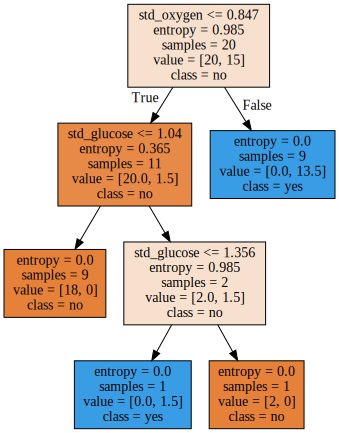

In [ ]:
graph = Source(export_graphviz(cls, 
                               out_file=None,
                               feature_names=['std_glucose', 'std_oxygen'],
                               class_names=['no', 'yes'],
                               filled = True))
display(SVG(graph.pipe(format='svg')))

style = "<style>svg{width:30% !important;height:30% !important;}</style>"
HTML(style)

#### Results are below

In [ ]:
X = df_train_normilize.loc[df_train_normilize['class']==0, ['std_glucose', 'std_oxygen']][10:]
X1 = df_train_normilize.loc[df_train_normilize['class']==1, ['std_glucose', 'std_oxygen']][10:]
X= pd.concat([X, X1])
y = df_train_normilize.loc[df_train_normilize['class']==0, ['class']][10:]
y1 = df_train_normilize.loc[df_train_normilize['class']==1, ['class']][10:]
y= pd.concat([y, y1])
y_res = cls.predict(X)
print("Accuracy: ",accuracy_score(y, y_res))
print("Precision: ",precision_score(y, y_res))
print("Recall: ",recall_score(y, y_res))

Accuracy:  0.7406380027739251
Precision:  0.21495327102803738
Recall:  0.7076923076923077


### Changing NaN values using KNN Imputer.

#### Now we will use KNN Imputer for 'std_oxygen' and 'std_glucose'

In [ ]:
def removeNAN_KNN(df_t):
  KNN_imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
  X_t =KNN_imputer.fit_transform(df_t[['std_glucose', 'class']])
  df_t.std_glucose=X_t[:,0]

  KNN_imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
  X_t =KNN_imputer.fit_transform(df_t[['std_oxygen', 'class']])
  df_t.std_oxygen=X_t[:,0]

  return df_t


In [ ]:
trans_duplicates = FunctionTransformer(remove_duplicates)
trans_date = FunctionTransformer(dateformat_consistent)
trans_age = FunctionTransformer(age_to_normal)
trans_gender = FunctionTransformer(gender_to_normal)
trans_pregnant = FunctionTransformer(pregnant_to_normal)
trans_metrics = FunctionTransformer(removeNAN_KNN)
trans_occupation = FunctionTransformer(occupation_to_normal)
trans_personal_info = FunctionTransformer(personal_info_to_normal)
trans_address = FunctionTransformer(address_to_normal)
trans_others = FunctionTransformer(others_to_normal)
trans_outliers = FunctionTransformer(change_outliers)
trans_power = FunctionTransformer(power_t)
trans_text = FunctionTransformer(text_normalize)

sk_pipe = Pipeline([("duplicates", trans_duplicates), 
                    ("date", trans_date),
                    ("age", trans_age),
                    ("gender", trans_gender),
                    ("pregnancy", trans_pregnant),
                    ("occupation", trans_occupation),
                    ("metrics", trans_metrics),
                    ("personal_info", trans_personal_info),
                    ("address", trans_address),
                    ("others", trans_others),
                    ("outliers", trans_outliers),
                    ("power", trans_power),
                    ("text", trans_text)])
df_train = load_data()
df_train_normilize = sk_pipe.transform(df_train)
df_train_normilize

,age,Male,kurtosis_oxygen,occupation,education-num,skewness_glucose,mean_glucose,std_oxygen,capital-gain,skewness_oxygen,kurtosis_glucose,fnlwgt,class,std_glucose,income>50K,mean_oxygen,hours-per-week,capital-loss,workclass,country
0,35,0,11.901183,"[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10.0,1.100895,NaN,-1.709603,0.0,209.980131,0.538392,145656.0,0.0,-1.245527,0,1.657191,24.0,0.0,"[0, 0, 0, 0, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,53,0,7.293155,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9.0,0.627064,93.109375,0.670061,0.0,209.980131,0.445701,131068.0,0.0,-0.335976,0,3.896321,40.0,0.0,"[0, 0, 0, 0, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,43,1,6.849557,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",13.0,0.132196,107.0546875,0.071887,0.0,55.304186,0.244217,156800.0,0.0,-0.475976,0,3.598662,50.0,0.0,"[1, 0, 0, 1, 0, 1, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,46,1,10.839312,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",11.0,-0.146138,109.328125,-0.757267,0.0,209.980131,0.380494,306352.0,0.0,0.884352,0,2.132107,40.0,0.0,"[0, 0, 0, 0, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
4,52,1,7.153364,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10.0,0.891195,NaN,0.554452,0.0,55.738168,0.320338,311177.0,0.0,-1.118334,0,3.721572,30.0,0.0,"[1, 0, 0, 1, 0, 1, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
736,43,1,8.480384,"[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10.0,0.074881,118.7890625,-0.930520,0.0,209.980131,0.160317,107190.0,0.0,-0.226072,0,2.751672,20.0,0.0,"[0, 0, 0, 0, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
737,43,1,10.590977,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",14.0,0.698647,121.859375,-1.553557,0.0,209.980131,0.247989,107302.0,0.0,-0.821247,0,2.071906,40.0,0.0,"[0, 0, 0, 0, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
738,59,1,8.721704,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10.0,-0.035706,121.1015625,-0.699732,0.0,209.980131,0.236479,189530.0,0.0,-0.762749,0,2.572742,35.0,0.0,"[0, 0, 0, 0, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
739,45,0,5.193876,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9.0,0.177381,NaN,0.453913,0.0,33.179282,0.075181,105281.0,0.0,0.143274,0,5.558528,40.0,1974.0,"[0, 0, 0, 0, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


#### Here is training using the same amount of data

In [ ]:
cls = DecisionTreeClassifier(criterion='entropy', class_weight= {0: 2, 1: 1.5})
df0 = df_train_normilize.loc[df_train_normilize['class']==0][:10]
df1 = df_train_normilize.loc[df_train_normilize['class']==1][:10]
df = pd.concat([df0, df1])
X = df[['std_glucose', 'std_oxygen']]
y = df[['class']]
cls.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight={0: 2, 1: 1.5},
                       criterion='entropy', max_depth=None, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=None,
                       splitter='best')

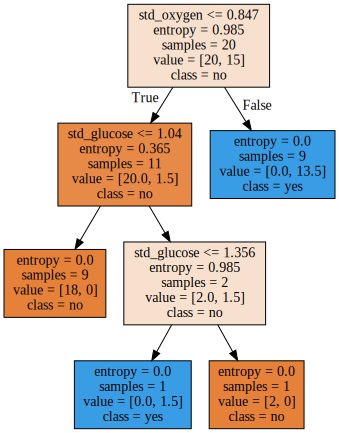

In [ ]:
graph = Source(export_graphviz(cls, 
                               out_file=None,
                               feature_names=['std_glucose', 'std_oxygen'],
                               class_names=['no', 'yes'],
                               filled = True))
display(SVG(graph.pipe(format='svg')))

style = "<style>svg{width:30% !important;height:30% !important;}</style>"
HTML(style)

#### Results are below

In [ ]:
X = df_train_normilize.loc[df_train_normilize['class']==0, ['std_glucose', 'std_oxygen']][10:]
X1 = df_train_normilize.loc[df_train_normilize['class']==1, ['std_glucose', 'std_oxygen']][10:]
X= pd.concat([X, X1])
y = df_train_normilize.loc[df_train_normilize['class']==0, ['class']][10:]
y1 = df_train_normilize.loc[df_train_normilize['class']==1, ['class']][10:]
y= pd.concat([y, y1])
y_res = cls.predict(X)
print("Accuracy: ",accuracy_score(y, y_res))
print("Precision: ",precision_score(y, y_res))
print("Recall: ",recall_score(y, y_res))

Accuracy:  0.7406380027739251
Precision:  0.21495327102803738
Recall:  0.7076923076923077


### As we can see, even though there were too little NaN values which we changed, using KNN Imputer gives us higher accuracy and precision scores. Consequently, it is better to use KNN Imputer.